In [1]:
import os
import re
import math
import pandas as pd
import numpy as np
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
from shapely.geometry import shape, Point
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from IPython.core.display import display, HTML

# Turn slice copy warnings off
pd.options.mode.chained_assignment = None

import findspark
findspark.init()
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, FloatType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
data_folder = './data/'

### Crime Data Exploration

This dataset examins NYPD complaint data from 2006 through 2017, giving us information about crime trends throughout that time period. The data is taken from New York City's opendata website, and the exact source is given in our project's readme. Let's start off by writing the data to a parquet file, which we will load to cut down on run times.

#### Data Cleaning and Preprocessing

In [3]:
df = spark.read.csv(data_folder + "NYPD_Complaint_Data_Historic.csv")
df.write.mode("overwrite").parquet(data_folder + "nypd.parquet")
df = spark.read.parquet(data_folder + "nypd.parquet")

In [4]:
df.show(5)

+---------+----------+--------+----------+--------+---+----------+---+--------------------+---+--------------------+---------+-----------+---------+------+--------------------+----------------+----+----+----+----+-------+------+----+-----+----+----+------------+-------------+--------------------+--------------------+----+-----+-------+----+
|      _c0|       _c1|     _c2|       _c3|     _c4|_c5|       _c6|_c7|                 _c8|_c9|                _c10|     _c11|       _c12|     _c13|  _c14|                _c15|            _c16|_c17|_c18|_c19|_c20|   _c21|  _c22|_c23| _c24|_c25|_c26|        _c27|         _c28|                _c29|                _c30|_c31| _c32|   _c33|_c34|
+---------+----------+--------+----------+--------+---+----------+---+--------------------+---+--------------------+---------+-----------+---------+------+--------------------+----------------+----+----+----+----+-------+------+----+-----+----+----+------------+-------------+--------------------+-----------------

Let's rename the columns to column names from the dataset description to make future manipulations easier.

In [5]:
cols = ["Comp_Num", "Comp_FR_Date", "Comp_FR_Time", "Comp_TO_Date", "Comp_TO_TIME", "Addr_PCT_CD",\
       "RPT_DT", "KY_DC", "OFNS_DESC", "PD_CD", "PD_DESC", "Crime_Completed", "LAW_CAT_CD", "BORO_NM",\
        "LOC_OF_OCCUR", "PREM_TYPE", "JURIS_DESC", "JURIS_CODE", "PARKS_NM", "HADEVELOPT", "HOUSING_PSA",\
       "X_COORD_CD", "Y_COORD_CD", "SUSP_AGE_GROUP", "SUSP_RACE", "SUSP_SEX", "TRANS_DIST", "Latitude",\
       "Longitude", "Lat_Lon", "PATROL_BORO", "STATION_NAME", "VIC_AGE_GROUP", "VIC_RACE", "VIC_SEX"]
df = df.toDF(*cols)
df.show(5)

+---------+------------+------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+---------------+-----------+---------+------------+--------------------+----------------+----------+--------+----------+-----------+----------+----------+--------------+---------+--------+----------+------------+-------------+--------------------+--------------------+------------+-------------+--------+-------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|Comp_TO_Date|Comp_TO_TIME|Addr_PCT_CD|    RPT_DT|KY_DC|           OFNS_DESC|PD_CD|             PD_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR|           PREM_TYPE|      JURIS_DESC|JURIS_CODE|PARKS_NM|HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|TRANS_DIST|    Latitude|    Longitude|             Lat_Lon|         PATROL_BORO|STATION_NAME|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+---------+------------+------------+------------+------------+-----------+----------+-----+--

We can start off by immediately dropping the features which do not seem important. We will leave information on the time of the crime, information about the crime itself, and demographic information about the victim and the perpretrator.

In [6]:
drop_list = ["Comp_FR_", "HADEVELOPT", "HOUSING_PSA", "JURIS_CODE", "JURIS_DESC", "LOC_OF_OCCUR",\
            "PARKS_NM", "PREM_TYPE", "RPT_DT", "STATION_NAME", "PATROL_BORO", "TRANS_DIST",\
            "X_COORD_CD", "Y_COORD_CD", "Addr_PCT_CD", "Lat_Lon", "Comp_TO_Date", "Comp_TO_TIME",\
             "KY_DC", "PD_CD", "PD_DESC"]
df = df.select([column for column in df.columns if column not in drop_list])

In [7]:
df.show(5)

+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------+-------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------+-------+
|595775572|  10/30/2008|    12:00:00|       GRAND LARCENY|      COMPLETED|     FELONY| BROOKLYN|          null|    BLACK|       F|40.665617714|-73.899076401|          <18|   BLACK|      F|
|375177250|  10/30/2008|    12:00:00|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|MANHATTAN|          null|     null|    null|40.751600254|-73.992043061|         null| UNKNOWN|      D|
|513357035|  10/30/2008|    12:00:00|CRIMINAL MISCHIEF.

Let's now clean the data. Let's remove crimes with invalid date, time, and location data; as our intended visualization will involve maps and this invalid data makes up an extremely small proportion of the dataset, it makes more sense to just remove it.

In [8]:
df = df.where(df["Comp_FR_Date"].isNotNull())
df = df.where(df["Comp_FR_Time"].isNotNull())
df = df.where(df["Latitude"].isNotNull())

Let's now create a column that combines the date and time information into a single datetime column.

In [9]:
df.registerTempTable("df")
date = spark.sql("SELECT Comp_Num, CONCAT(Comp_FR_Date, ' ',  Comp_FR_Time) as Date FROM df")
df = df.join(date, ["Comp_Num"])
df = df.withColumn("Date", to_timestamp(df.Date, 'MM/dd/yyyy HH:mm:ss'))
df.show(5)

+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------+-------+-------------------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|               Date|
+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------+-------+-------------------+
|100027190|  08/01/2008|    17:23:00|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|MANHATTAN|          null|     null|    null|40.747327396|-73.976961498|         null|       UNKNOWN|      D|2008-08-01 17:23:00|
|100030303|  06/23/2016|    21:00:00|       GRAND LARCENY|      COMPLETED|     FELONY|    BRONX|          null|     null|    null|40.8638386

Let's now drop the old date and time columns, and write this to a parquet. This contains all of the information that we will need at the moment. In addition to this, our dataset only proports to be from 2006-2017; thus, let's also remove any rows with dates that are less than 2006.

In [10]:
df = df.drop("Comp_FR_Date").drop("Comp_FR_Time")
df = df.filter(df.Date >= lit("2006-01-01"))
df.write.mode("overwrite").parquet(data_folder + "nypd_filtered.parquet")

Loading the data again, we can now proceed with analysis of the data.

#### Crime Dataset Data Analysis

In [11]:
df = spark.read.parquet(data_folder + "nypd_filtered.parquet")

In [12]:
df.show(5)

+---------+--------------------+---------------+-----------+---------+--------------+--------------+--------+------------+-------------+-------------+--------------+-------+-------------------+
| Comp_Num|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|     SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|               Date|
+---------+--------------------+---------------+-----------+---------+--------------+--------------+--------+------------+-------------+-------------+--------------+-------+-------------------+
|100003098|OFFENSES AGAINST ...|      COMPLETED|MISDEMEANOR|MANHATTAN|         25-44|BLACK HISPANIC|       M|40.811130194|-73.936714506|        25-44|WHITE HISPANIC|      F|2014-10-02 13:40:00|
|100023642|CRIMINAL MISCHIEF...|      COMPLETED|     FELONY|    BRONX|         18-24|         BLACK|       M|40.791151867|-73.884371919|         null|       UNKNOWN|      E|2013-11-09 19:15:00|
|100038353|      FELONY ASSAUL

Let's first examine the offense descriptions, by finding the top ten most commonly occurring crimes.

In [13]:
df.registerTempTable("df")
query = """select OFNS_DESC, min(LAW_CAT_CD) as category, count(OFNS_DESC) as count 
    from df
    group by ofns_desc
    order by count desc
    limit 10"""
spark.sql(query).show()

+--------------------+-----------+------+
|           OFNS_DESC|   category| count|
+--------------------+-----------+------+
|       PETIT LARCENY|MISDEMEANOR|981460|
|       HARRASSMENT 2|  VIOLATION|732754|
|ASSAULT 3 & RELAT...|MISDEMEANOR|622173|
|CRIMINAL MISCHIEF...|     FELONY|600613|
|       GRAND LARCENY|     FELONY|510969|
|     DANGEROUS DRUGS|     FELONY|389070|
|OFF. AGNST PUB OR...|MISDEMEANOR|324903|
|             ROBBERY|     FELONY|226287|
|      FELONY ASSAULT|     FELONY|223877|
|            BURGLARY|     FELONY|215315|
+--------------------+-----------+------+



As can be seen, the most common crime committed is petit larceny, which New York defines to be the theft of objects with monetary value of no more than 1000 dollars. Grand larceny is also on the list, which is for items of value greater than 1000 dollars. Most of the items on the list are felonies (the most severe crimes), while only a few are misdemeanors (the least severe crime category). There is only one of the middle category on the list. Let's now examine the counts of the three categories in total.

In [14]:
df.groupBy("LAW_CAT_CD").count().sort(col("count").desc()).show()

+-----------+-------+
| LAW_CAT_CD|  count|
+-----------+-------+
|MISDEMEANOR|3414803|
|     FELONY|1839034|
|  VIOLATION| 745632|
+-----------+-------+



The majority of crimes committed are misdemeanors. Only 745,000 violations were committed over this timeframe, and 733,000 of them were in the "harassment 2" category, which corresponds with harrassment in the 2nd degree. Otherwise, we can see that nearly 1/3 of the felonies are criminal mischief charges, with grand larceny also taking up a similar proportion. 

Let's now look at the count per borough.

In [15]:
df.groupBy("BORO_NM").count().sort(col("count").desc()).show()

+-------------+-------+
|      BORO_NM|  count|
+-------------+-------+
|     BROOKLYN|1786643|
|    MANHATTAN|1434961|
|        BRONX|1300000|
|       QUEENS|1183943|
|STATEN ISLAND| 284300|
|         null|   9622|
+-------------+-------+



Brooklyn has the most crimes committed by a decent margin, followed by Manhattan, the Bronx, and Queens. Staten Island is far behind, which makes sense due to its smaller size and population. Let's now examine how much crime happens in different hours of the day.

In [16]:
hours = df.select("Date", "LAW_CAT_CD").withColumn("Hour", hour(df.Date)).drop("Date")
hours.groupBy("Hour").count().sort(col("Hour").asc()).show()

+----+------+
|Hour| count|
+----+------+
|   0|284045|
|   1|206995|
|   2|165946|
|   3|139862|
|   4|122590|
|   5| 85913|
|   6| 87574|
|   7|124400|
|   8|201464|
|   9|221439|
|  10|230515|
|  11|236269|
|  12|329199|
|  13|282808|
|  14|319956|
|  15|361601|
|  16|344267|
|  17|345283|
|  18|354435|
|  19|342792|
+----+------+
only showing top 20 rows



We can see from this table that the amount of crimes starts off fairly high, decreases as the night goes on,  and heats a peak in the mid-afternoon. Let's plot this data, along with the trends for each individual crime type.

In [17]:
total = hours.groupBy("Hour").count().sort(col("Hour").asc())
categories = hours.groupBy("Hour", "LAW_CAT_CD").count().orderBy(col("Hour").asc(), "LAW_CAT_CD")
total = total.toPandas()
categories = categories.toPandas()

<BarContainer object of 24 artists>

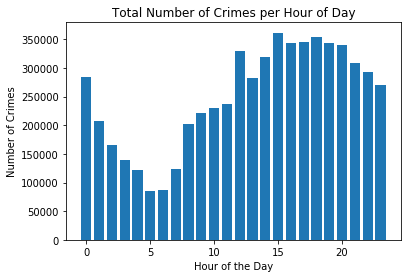

In [18]:
plt.title("Total Number of Crimes per Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes")
plt.bar(total["Hour"], total["count"])

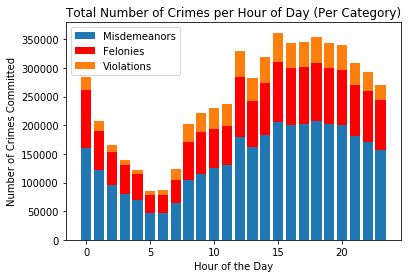

In [19]:
felonies = categories[categories.LAW_CAT_CD == "FELONY"].reset_index(drop=True)
misdemeanors = categories[categories.LAW_CAT_CD == "MISDEMEANOR"].reset_index(drop=True)
violations = categories[categories.LAW_CAT_CD == "VIOLATION"].reset_index(drop=True)

plt.title("Total Number of Crimes per Hour of Day (Per Category)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes Committed")

p1 = plt.bar(misdemeanors["Hour"], misdemeanors["count"])
p2 = plt.bar(felonies["Hour"], felonies["count"], bottom=misdemeanors["count"], color="red")
p3 = plt.bar(violations["Hour"], violations["count"], bottom=(misdemeanors["count"] + felonies["count"]), color="C1")
plt.legend((p1[0], p2[0], p3[0]), ('Misdemeanors', 'Felonies', 'Violations'))

The individual categories follow a similar trend as the total. There is a consistent ordering between the number of misdemeanors, felonies, and violations for every hour. For the last bit of our preliminary analysis, let's use maps to show the geographical trends of the data.

As there is a lot of data, let's restrict our daily maps to just a single day. Let's choose five years before today's date, November 25th 2013.

In [20]:
day_df = df.filter(df["Date"].between('2013-11-25 00:00:00','2013-11-25 23:59:00'))
day_df.show(5)

+---------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------------+-------+-------------------+
| Comp_Num|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|            VIC_RACE|VIC_SEX|               Date|
+---------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------------+-------+-------------------+
|542665858|OFFENSES AGAINST ...|      COMPLETED|MISDEMEANOR|   QUEENS|         25-44|  UNKNOWN|       M|40.706599944|-73.795606957|        18-24|             UNKNOWN|      F|2013-11-25 19:25:00|
|746012014|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|    BRONX|          null|     null|    null| 40.84521634|-73.922445246|        25-44|               BLACK|      M|2013-11-25 16:48:00|
|808274644|OFF. AGNST PUB

Let's filter out all irrelevant data and convert it into a pandas dataframe, which will allow us to plot it with folium.

In [21]:
day_df = day_df.select(["Latitude", "Longitude", "LAW_CAT_CD", "OFNS_DESC"])
day_df = day_df.toPandas()
day_df["Latitude"] = pd.to_numeric(day_df["Latitude"])
day_df["Longitude"] = pd.to_numeric(day_df["Longitude"])

Let's set up our map so we see the offense description if we click on the marker. Furthermore, let's color-code it by the severity of the violation: red for felonies, orange for violations, and blue for misdemeanors (there is no yellow marker in folium). For this map, we will also show the borders of the boroughs.

In [22]:
def color(category):
    if category == "FELONY":
        return "red"
    elif category == "VIOLATION":
        return "orange"
    else: # misdemeanor
        return "blue"

In [23]:
borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')))
nyc_loc = [40.7128, -73.9]

day_map = folium.Map(location = nyc_loc, zoom_start = 11)

# Shuffle the data to show random sample
day_df = day_df.sample(frac=1).reset_index(drop=True)
# We reduce the size, as too many markers prevents the map from rendering.
for i in range(300):
    folium.Marker([day_df.iloc[i]['Latitude'], day_df.iloc[i]['Longitude']], \
        popup=day_df.iloc[i]['OFNS_DESC'], icon=folium.Icon(color=color(day_df.iloc[i]["LAW_CAT_CD"])))\
        .add_to(day_map)

folium.GeoJson(
    borough_edge,
    name='geojson',
    style_function = lambda x: {'fillOpacity': 0}
).add_to(day_map)
    
day_map

Let's also make a heatmap for the day's crimes.

In [24]:
heat_data = [[row['Latitude'],row['Longitude']] for index, row in day_df.iterrows()]

heat_map = folium.Map(location = nyc_loc, zoom_start = 11.5)
HeatMap(heat_data).add_to(heat_map)

heat_map

Let's now visualize crime over postal codes.

In [25]:
df.registerTempTable("table")
query = """select latitude, longitude from table where rand() <= 0.0167"""
subset = spark.sql(query)
subset.count()

100574

We selected roughly 100,000 data points, which is good for our purposes. Let's now find their postal codes and plot them.

In [26]:
subset = subset.toPandas()
subset["code"] = ""

In [27]:
# Read postal code json
with open('data/nyc-postcode.json') as f:
    codes = json.load(f)

In [28]:
for index, row in subset.iterrows():
    point = Point(float(subset.iloc[index]["longitude"]), float(subset.iloc[index]["latitude"]))
    found = False
    for feature in codes['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            subset.iloc[index]["code"] =feature["properties"]["postalCode"]
            found = True
            break
subset = subset[subset.code != ""]

In [29]:
zipcodes = set()
for feature in codes["features"]:
    zipcodes.add(int(feature["properties"]["postalCode"]))

In [30]:
counts = subset.groupby("code")["code"].count()
counts = pd.DataFrame({"zipcode": counts.index.astype(int), "count": counts}).reset_index(drop=True)
for code in zipcodes:
    if code not in counts["zipcode"].unique():
        counts = counts.append({"zipcode": code, "count": 0}, ignore_index=True)
# drop invalid zipcodes
counts = counts[counts.zipcode >= 10000]
counts = counts.sort_values(by="zipcode")

In [31]:
population = pd.read_csv("data/population_by_zip_2010.csv")
population.head()

population  minimum_age  maximum_age  gender  zipcode          geo_id
0          50         30.0         34.0  female    61747  8600000US61747
1           5         85.0          NaN    male    64120  8600000US64120
2        1389         30.0         34.0    male    95117  8600000US95117
3         231         60.0         61.0  female    74074  8600000US74074
4          56          0.0          4.0  female    58042  8600000US58042

We want to only examine the rows where minimum_age, maximum_age, and gender are all empty.

In [32]:
population = population[(pd.isnull(population.minimum_age)) & (pd.isnull(population.gender))]
population = population.drop(["minimum_age", "maximum_age", "gender", "geo_id"], axis=1)
population.head()

population  zipcode
36        27669    91324
116        4449    72632
127         473    72739
135        1685    27305
178       24425     1843

Let's now merge these dataframes into one.

In [33]:
stats = pd.merge(counts, population, how='left')
stats["zipcode"] = stats["zipcode"].astype(str)
stats.loc[pd.isnull(stats["population"]), "population"] = 0
stats["rate"] = stats["count"] / stats["population"]
stats[stats["count"] == 0]["rate"] = 0
stats.head()

zipcode  count  population      rate
0   10001   1380     21102.0  0.065397
1   10002   1100     81410.0  0.013512
2   10003   1111     56024.0  0.019831
3   10004     96      3089.0  0.031078
4   10005     54      7135.0  0.007568

Let's scale the rate to be between zero and one.

In [34]:
max_rate = np.max(stats[np.isfinite(stats["rate"])]["rate"])
stats["rate"] = stats["rate"] / max_rate
stats.loc[~np.isfinite(stats["rate"]), "rate"] = 1 
stats.head()

zipcode  count  population      rate
0   10001   1380     21102.0  0.501374
1   10002   1100     81410.0  0.103591
2   10003   1111     56024.0  0.152036
3   10004     96      3089.0  0.238265
4   10005     54      7135.0  0.058024

Let's take a peek at the data to see if the rates fall in a near-uniform distribution, which would be ideal for our purposes.

In [35]:
stats[stats["rate"] < 1].sort_values(by="rate", ascending=False).head()

zipcode  count  population      rate
15    10018    605      5229.0  0.887040
0     10001   1380     21102.0  0.501374
6     10007    277      6988.0  0.303902
33    10036    922     24711.0  0.286053
139   10474    389     12281.0  0.242841

As can be seen, there are two large outliers here with values greater than 0.5. Everything else falls between 0 and 0.33. Let's rescale again so that the value corresponding to zip code 10007 is the new high, and see if that gives us coherent results.

In [36]:
stats["rate"] = stats["rate"] / stats.loc[6, "rate"]
stats.loc[stats["rate"] > 1, "rate"] = 1

We have now scaled all of the values between zero and one. Let's now plot these trends on the map.

In [38]:
rate_map = folium.Map(location=[40.75, -74])

rate_map.choropleth(
    geo_data=codes, 
             data=stats,
             columns=['zipcode', 'rate'],
             key_on = 'feature.properties.postalCode',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
             legend_name="Relative Crime Rate",
             highlight=True)

folium.GeoJson(
    codes,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)).add_to(rate_map)

rate_map

For comparison, let's do the same for pure crime counts and population.

In [39]:
rate_map = folium.Map(location=[40.75, -74])

rate_map.choropleth(
    geo_data=codes, 
             data=stats,
             columns=['zipcode', 'count'],
             key_on = 'feature.properties.postalCode',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
             legend_name="Number of Crimes Committed in Sample",
             highlight=True)

folium.GeoJson(
    codes,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)).add_to(rate_map)

rate_map

In [41]:
rate_map = folium.Map(location=[40.75, -74])

rate_map.choropleth(
    geo_data=codes, 
             data=stats,
             columns=['zipcode', 'population'],
             key_on = 'feature.properties.postalCode',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
             legend_name="Population",
             highlight=True)

folium.GeoJson(
    codes,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)).add_to(rate_map)

rate_map